In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("seaborn")
%matplotlib inline

import warnings
warnings.simplefilter("ignore")
from binance.client import Client
import time
import statistics as stats
from datetime import datetime
import random
import torch
import torch.nn as nn
import mlfinlab
import glob

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df_dict = {}

directory = '../data/final_data'
all_files = glob.glob(directory + "/*.csv")

for file in all_files:
    
    df = pd.read_csv(file, index_col=None, header=0).drop(columns=['Unnamed: 0'])
    
    df_dict[file.split('\\')[1][:-10]] = df

In [4]:
df_dict['ADA'].head()

,Open Time,Time of Day,Open,High,Low,Close,Volume,Close Time,Quote asset vol,Num trades,...,fastd,SAR,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,Spinning Top
0,2017-12-04 03:00:00.000,10800,0.000011,0.000012,0.000011,0.000011,1991422.0,2017-12-04 03:29:59.999,22.743129,220.0,...,65.932193,0.000009,31.202095,-82.432432,-1.115105e+07,-2.522361e+06,45800177.0,1.994172e-07,1.994172e-07,0.0
1,2017-12-04 03:30:00.000,12600,0.000011,0.000011,0.000011,0.000011,4123602.0,2017-12-04 03:59:59.999,46.809428,316.0,...,56.017794,0.000009,29.874065,-98.780488,-1.494476e+07,-3.558265e+06,41676575.0,2.030303e-07,2.030303e-07,0.0
2,2017-12-04 04:00:00.000,14400,0.000011,0.000011,0.000011,0.000011,2136313.0,2017-12-04 04:29:59.999,24.021883,221.0,...,22.684461,0.000009,28.369373,-96.103896,-1.632708e+07,-4.098395e+06,39540262.0,2.006710e-07,2.006710e-07,1.0
3,2017-12-04 04:30:00.000,16200,0.000011,0.000011,0.000011,0.000011,2828688.0,2017-12-04 04:59:59.999,31.831697,257.0,...,9.387506,0.000009,29.840368,-88.888889,-1.745855e+07,-4.306790e+06,42368950.0,2.006230e-07,2.006230e-07,0.0
4,2017-12-04 05:00:00.000,18000,0.000011,0.000011,0.000011,0.000011,1820903.0,2017-12-04 05:29:59.999,20.481454,218.0,...,31.117726,0.000009,35.496836,-80.555556,-1.715507e+07,-3.903954e+06,44189853.0,2.034357e-07,2.034357e-07,1.0


In [5]:
coin_list = list(df_dict.keys())

In [ ]:
# 'Close_pct'

In [6]:
columns = list(df_dict[coin_list[0]].columns)
not_quant = ['Open Time','Close Time']
quants = [i for i in columns if i not in not_quant]

In [7]:
coin_list

['ADA', 'BNB', 'ETH', 'LINK', 'LTC', 'XRP']

In [66]:
class Process():
    def __init__(self, data, test_size=.1, seq_len=25):
        self.seq_len = seq_len       
        self.test_size = test_size
        self.sequences = []
        self.data = data
        self.normalize_data = None
        #self.reduce()
        self.create_sequences()
        
    def reduce(self):
        
        #lower = self.data.shape[0] - int(.3*self.data.shape[0]) - 336
        #upper = self.data.shape[0] - int(.3*self.data.shape[0]) + 336
        
        current = self.data.shape[0]
        
        while current%self.seq_len!=0:
            current -= 1
            
        self.data = self.data[:current]
        
    def create_sequences(self):
        
        #indices = list(range(0, self.data.shape[0], self.seq_len))
        
        for i in range(self.data.shape[0] - self.seq_len):
            self.sequences.append(torch.tensor(list(self.data[i:i+self.seq_len])))
            
        self.sequences = torch.stack(self.sequences)
        self.sequences = self.sequences.reshape(self.sequences.shape[0], self.seq_len, 1)
        
        
    def separate(self):
        #split_off = int(self.sequences.shape[0] * self.test_size)
        
        lower = self.data.shape[0] - int(self.test_size*self.data.shape[0]) - int(.05*self.data.shape[0])
        upper = self.data.shape[0] - int(self.test_size*self.data.shape[0]) + int(.05*self.data.shape[0])
        
        training = self.sequences[:lower]
        testing = self.sequences[upper:]
        
        training_x, training_y = training[:, :-1, :], training[:, -1, :]
        testing_x, testing_y = testing[:, :-1, :], testing[:, -1, :]
        
        training_data = (training_x, training_y)
        testing_data = (testing_x, testing_y)
        
        return training_data, testing_data
    
    def normalize(self):
        self.normalize_data = (self.data - stats.mean(self.data))/stats.stdev(self.data)
        
        

In [70]:
tensor_files='E:/Users/Justin/Desktop/Course Folders 2020/practicum/tensors/25'

In [68]:
li4={}
li={}

for coin in coin_list:
    print(coin, ': ')
    close = df_dict[coin]['Close']
    process = Process(close)
    print(process.sequences.shape)
    li4[coin]=process.sequences
    train, test = process.separate()
    print('training: ', train[0].shape, train[1].shape)
    print('testing: ', test[0].shape, test[1].shape)
    print('\n')
    li[coin] = train, test

ADA : 
torch.Size([51486, 25, 1])
training:  torch.Size([43785, 24, 1]) torch.Size([43785, 1])
testing:  torch.Size([2551, 24, 1]) torch.Size([2551, 1])


BNB : 
torch.Size([58160, 25, 1])
training:  torch.Size([49458, 24, 1]) torch.Size([49458, 1])
testing:  torch.Size([2884, 24, 1]) torch.Size([2884, 1])


ETH : 
torch.Size([58180, 25, 1])
training:  torch.Size([49475, 24, 1]) torch.Size([49475, 1])
testing:  torch.Size([2885, 24, 1]) torch.Size([2885, 1])


LINK : 
torch.Size([54517, 25, 1])
training:  torch.Size([46361, 24, 1]) torch.Size([46361, 1])
testing:  torch.Size([2702, 24, 1]) torch.Size([2702, 1])


LTC : 
torch.Size([58180, 25, 1])
training:  torch.Size([49475, 24, 1]) torch.Size([49475, 1])
testing:  torch.Size([2885, 24, 1]) torch.Size([2885, 1])


XRP : 
torch.Size([52839, 25, 1])
training:  torch.Size([44935, 24, 1]) torch.Size([44935, 1])
testing:  torch.Size([2618, 24, 1]) torch.Size([2618, 1])




In [ ]:
# 'Close_pct'

In [ ]:
li4={}
li={}

for coin in coin_list:
    print(coin, ': ')
    close = df_dict[coin]['Close_pct']
    process = Process(close)
    print(process.sequences.shape)
    li4[coin]=process.sequences
    train, test = process.separate()
    print('training: ', train[0].shape, train[1].shape)
    print('testing: ', test[0].shape, test[1].shape)
    print('\n')
    li[coin] = train, test

In [71]:
torch.save(li4, tensor_files+'/complete25.pth')
torch.save(li, tensor_files+'/complete25train_test.pth')

In [ ]:
process.sequences

In [25]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, 60)
        self.fc4 = nn.Linear(60, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return self.sigmoid(self.fc4(x))

In [26]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True).to(device)
        self.l1 = nn.Linear(hidden_dim, output_dim).to(device)
        #self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        #h0=h0.to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        #c0=c0.to(device)
        output, (hn, cn) = self.lstm(x.to(device), (h0.detach().to(device), c0.detach().to(device)))
        #out = self.relu(self.l1(output[:, -1, :]))
        out = self.l1(output[:, -1, :])
        return out

In [27]:
class GRU(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.l1 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_()
        output, (hn, cn) = self.gru(x, (h0.detach(), c0.detach())) 
        out = self.l1(output[:, -1, :])
        return out

In [61]:
class Optimization:
    
    def __init__(self, model, loss, weights_path, coin, training_data, testing_data, epochs=50, batch_size=1):
            
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=.01)
        self.criterion = loss
        self.x_train, self.y_train = training_data
        self.x_test, self.y_test = testing_data
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_list = []
        self.train_time_list = []
        self.test_time_list = []
        self.results = []
        self.coin=coin
        self.weights_path=weights_path
        
    def train(self):
        
        for _ in range(self.epochs):
        
            start = time.time()
            
            #indices = random.sample(list(range(0, self.x_train.shape[0])), k=5_000)
            indices = random.sample(list(range(0, self.x_train.shape[0])), k=10_000)

            #for i in range(self.x_train.shape[0]):
            for i in indices:
                
                if self.batch_size > 1:
                    
                    sequence = self.x_train[indices[indices.index(i)*self.batch_size]:indices[indices.index(i)*self.batch_size+self.batch_size]].to(device)
                    label = self.x_train[indices[indices.index(i)*self.batch_size]:indices[indices.index(i)*self.batch_size+self.batch_size]].to(device)

                else:
                    sequence = self.x_train[i].reshape(self.batch_size, self.x_train.shape[1], 1).to(device)
                    label = self.y_train[i].to(device)
                
                self.optimizer.zero_grad()
                #self.model.zero_grad()
                result = self.model(sequence)
                loss = self.criterion(result, label)
                self.loss_list.append(loss.item())
                loss.backward()
                self.optimizer.step()
                                
            end = time.time()
            tot_time = end - start
            
            self.train_time_list.append(tot_time)
            
            if _%2==0 or _==self.epochs-1:

                print('Epoch: ', _ + 1, 'Time: ', self.train_time_list[-1], 'Loss: ', sum(self.loss_list))
            
                saver=(self.epochs, self.optimizer, self.criterion, self.model.state_dict(), self.model)
                
                torch.save(saver, self.weights_path+self.coin+'params.pth')
            
            self.loss_list=[]
                
    def test(self):
        start = time.time()
        
        self.model.load_state_dict(torch.load(self.weights_path+self.coin+'params.pth')[3])
        
        with torch.no_grad():
        
            for i in range(self.x_test.shape[0]):

                sequence = self.x_test[i].to(device)
                #label = self.y_test[i]

                result = self.model(sequence.reshape(self.batch_size, sequence.shape[0], 1))
                self.results.append(result)

        
        end = time.time()
        tot_time = end-start
        self.test_time_list.append(tot_time)
    
    def min_max_scaling(self, x):
        return (x-torch.min(x))/(torch.max(x)-torch.min(x))
    
   

In [24]:
li['ADA'][0][0].shape

torch.Size([41210, 24, 1])

In [29]:
weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/'

In [72]:
def min_max_scaling(x):
    return (x-torch.min(x))/(torch.max(x)-torch.min(x))

In [55]:
input_dim = 1
hidden_dim = 24
n_layers = 5
output_dim = 1

model = LSTM(input_dim, hidden_dim, n_layers, output_dim)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')

#optimizer = torch.optim.SGD(model.parameters(), lr=.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [62]:
coin='ADA'
train, test=li[coin]
print(coin)
optimize = Optimization(model, criterion, weights_path, coin, train, test, epochs=15)
optimize.train()

ADA
Epoch:  1 Time:  152.57839488983154 Loss:  0.001727681139875188
Epoch:  3 Time:  152.41341161727905 Loss:  0.0007587072779339167
Epoch:  5 Time:  153.8522183895111 Loss:  0.0007568692625206127
Epoch:  7 Time:  152.00651931762695 Loss:  0.0007523928864851607
Epoch:  9 Time:  146.1497049331665 Loss:  0.0007499804718756512
Epoch:  11 Time:  147.79075956344604 Loss:  0.0007576726573049542
Epoch:  13 Time:  147.03528428077698 Loss:  0.0007516282426762449
Epoch:  15 Time:  147.79920268058777 Loss:  0.0007521786323842474


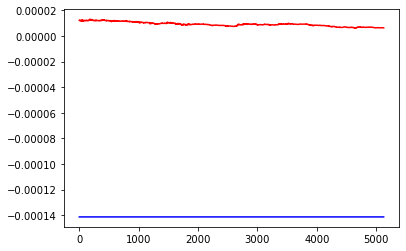

In [63]:
optimize.test()

plt.plot(li['ADA'][1][1], color='r')
plt.plot(optimize.results, color='b')

plt.show()

In [15]:
weights_path='E:/Users/Justin/Desktop/Course Folders 2020/practicum/weights/'

for coin in coin_list:
    
    input_dim = 1
    hidden_dim = 24
    n_layers = 2
    output_dim = 1

    model = LSTM(input_dim, hidden_dim, n_layers, output_dim)

    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss(reduction='mean')

    #optimizer = torch.optim.SGD(model.parameters(), lr=.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    
    
    train, test=li[coin]
    print(coin)
    optimize = Optimization(model, criterion, weights_path, coin, train, test, epochs=15)
    optimize.train()
    print('\n')

ADA


TypeError: __init__() missing 1 required positional argument: 'testing_data'

In [45]:
coin='ADA'
optimize = Optimization(optimizer, model, criterion, weights_path, coin, train, test, epochs=15)

optimize.test()

plt.plot(li['ADA'][1][1], color='r')
plt.plot(optimize.results, color='b')

plt.show()

AttributeError: 'MSELoss' object has no attribute 'copy'

In [ ]:
li['ADA'][1][1].shape

In [ ]:
plt.plot(li['ADA'][1][1])
plt.plot(optimize.results)

plt.show()

In [ ]:
#minisgd
#sgd

In [ ]:
targets = 'BTC LINK VET BNB ETH XRP XTZ LTC'

In [ ]:
optimize.test()

In [ ]:
plt.plot(optimize.results)
plt.plot(test[1])

plt.show()

In [ ]:
model = GRU(input_dim, hidden_dim, n_layers, output_dim)

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(reduction='mean')

#optimizer = torch.optim.SGD(model.parameters(), lr=.1)
optimiser = torch.optim.Adam(model.parameters(), lr=.01)

optimize = Optimization(optimizer, model, criterion, train, test)

In [ ]:
plt.plot(test[1])
plt.plot(optimize.results)

plt.show()